In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler


c:\Users\intern2\.conda\envs\machineLearnng\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [99]:
#loading data

asset_pchange_list = []
asset_price_list = []
asset_name_list = []

df = pd.read_excel('PCA1.xlsx', sheet_name=0)
date_list = np.flip(df.iloc[:,0].to_numpy().astype('datetime64[D]'))
num_of_asset = len(df.columns)
for i in range(1, num_of_asset):
    asset_array = df.iloc[:,i].to_numpy()
    mask = ~np.isnan(asset_array)
    asset_array_no_na = asset_array[mask]
    asset_price_list.append(np.flip(asset_array_no_na))
    asset_name_list.append(df.columns[i])

p_date_list = date_list[1:]
for i in range(len(asset_price_list)):
    asset_price = asset_price_list[i]
    print(asset_name_list[i], i)
    if i < 11 or (len(asset_price_list)>20 and i<23):
        try:
            diff_list = np.diff(asset_price) / asset_price[:-1]
        except:
            print(i)
    else:
        diff_list = np.diff(asset_price)
    asset_pchange_list.append(diff_list)

# training_asset_pchange_list = np.array(asset_pchange_list)[:, :960]
# testing_asset_pchange_list = np.array(asset_pchange_list)[:, 960:]

# training_p_date_list = np.array(p_date_list)[:960]
# testing_p_date_list = np.array(p_date_list)[960:]

# training_asset_price_list = np.array(asset_price_list)[:,:960]
# testing_asset_price_list = np.array(asset_price_list)[:,960:]

# training_date_list = np.array(date_list)[:960]
# testing_date_list = np.array(date_list)[960:]



SPX index 0
MXEF Index 1
USCRWTIC Index 2
USDEUR Curncy 3
USDJPY Curncy 4
USDCNH Curncy 5
USDAUD Curncy 6
USDKRW Curncy 7
USDINR Curncy 8
MOVE Index 9
VIX Index 10
USGG2YR Index 11
USGG5YR Index 12
USGG10YR Index 13


In [100]:
class All_TSMD():
    def __init__(self, price_lists, price_date_list, data_lists, data_date_list, asset_name_list, target_index, windows=10, n_closest=5, is_p_change = True):
        self.__price_lists = price_lists
        self.__price_date_list = price_date_list
        self.__data_lists = data_lists
        self.__data_date_list = data_date_list
        self.__target_index = target_index
        self.__windows = windows
        self.__n_closest = n_closest
        self.__is_p_change = is_p_change
        self.__asset_name_list = asset_name_list

        before_target_data_lists = np.array(data_lists)[:, :target_index]
        target_data_lists = np.array(data_lists)[:, target_index:target_index+windows]
        self.__before_target_data_lists = before_target_data_lists
        self.__target_data_lists = target_data_lists

    def fit(self):
        all_asset_e_dist_list = []
        windows = self.__windows
        is_p_change = self.__is_p_change
        before_target_data_lists = self.__before_target_data_lists
        n_closest = self.__n_closest
        target_data_lists = self.__target_data_lists
        for i in range(len(before_target_data_lists)):
            e_dist_list = []
            asset_data = before_target_data_lists[i]
            target_data = target_data_lists[i]
            for j in range(len(asset_data) - windows + 1):
                if is_p_change:
                    compare_data = asset_data[j:j+windows]
                    e_dist = np.linalg.norm(np.array(compare_data) - np.array(target_data))
                    e_dist_list.append(e_dist)
                else:
                    compare_data = TimeSeriesScalerMeanVariance().fit_transform([asset_data[j:j+windows]])[0]
                    e_dist = np.linalg.norm(np.array(compare_data) - TimeSeriesScalerMeanVariance().fit_transform([target_data])[0])
                    e_dist_list.append(e_dist)
            all_asset_e_dist_list.append(e_dist_list)
        cumulative_asset_e_dist_list = reduce(np.add, all_asset_e_dist_list)
        n_smallest_e_dist_list = np.partition(cumulative_asset_e_dist_list, n_closest)[:n_closest]
        n_smallest_index = np.where(np.isin(cumulative_asset_e_dist_list, n_smallest_e_dist_list))[0]

        self.cumulative_asset_e_dist_list = cumulative_asset_e_dist_list
        self.n_smallest_e_dist_list = n_smallest_e_dist_list
        self.n_smallest_index = n_smallest_index
        print(n_smallest_index)

    def plot(self, show_mean = True):
        is_p_change = self.__is_p_change
        asset_price_lists = self.__price_lists
        asset_price_date_list = self.__price_date_list

        target_index = self.__target_index
        windows = self.__windows
        n_smallest_index = self.n_smallest_index
        asset_name_list = self.__asset_name_list
        all_prediction_list = self.__all_prediction_list
        new_date_list = self.__new_date_list
        extra_windows = 0

        if is_p_change:
            extra_windows = 1
        for i in range(len(asset_price_lists)):
            asset_price_list = asset_price_lists[i]
            plt.figure(figsize=(26, 9))
            plt.plot(asset_price_date_list[:len(asset_price_list)], asset_price_list)
            for j in range(len(n_smallest_index)):
                index = n_smallest_index[j]
                plt.plot(asset_price_date_list[index:index+windows+extra_windows], asset_price_list[index:index+windows+extra_windows], 'r-')
                plt.plot(new_date_list, all_prediction_list[i][j], "k-", alpha=.5)
            np_all_prediction_list = np.array(all_prediction_list[i])
            mean_list = np.mean(np_all_prediction_list, axis=0)
            plt.plot(new_date_list, mean_list, "g-")
            plt.plot(asset_price_date_list[target_index:target_index+windows+extra_windows], asset_price_list[target_index:target_index+windows+extra_windows], color="gold")
            
            
            plt.xlabel('Date')
            plt.ylabel('Value')
            plt.title(asset_name_list[i])
            plt.show()

        pass

    def transform(self, n_data_points):
        n_smallest_index = self.n_smallest_index
        data_lists = self.__data_lists
        data_date_list = self.__data_date_list
        
        price_lists = self.__price_lists
        asset_price_date_list = self.__price_date_list

        is_p_change = self.__is_p_change
        windows = self.__windows 
        target_index = self.__target_index
              
        all_prediction_list = []
        for i in range(len(data_lists)):
            data_list = data_lists[i]
            price_list = price_lists[i]
            asset_prediction_list = []
            for index in n_smallest_index:
                latest_price = price_list[target_index + windows]
                latest_date = asset_price_date_list[target_index + windows]
                new_data_list = [latest_price]
                new_date_list = [latest_date]
                for j in range(n_data_points - 1):
                    if i < 11 or (len(asset_price_list)>20 and i<23):
                        latest_price *= (1 + data_list[index+windows+j])
                    else:
                        latest_price += data_list[index+windows+j]

                    latest_date += np.timedelta64(7, 'D')
                    new_date_list.append(latest_date)
                    new_data_list.append(latest_price)
                asset_prediction_list.append(new_data_list)
            all_prediction_list.append(asset_prediction_list)
        new_date_list = np.array(new_date_list).astype('datetime64[D]')
        
        self.__all_prediction_list = all_prediction_list
        self.__new_date_list = new_date_list
                

        


[217 295 918]


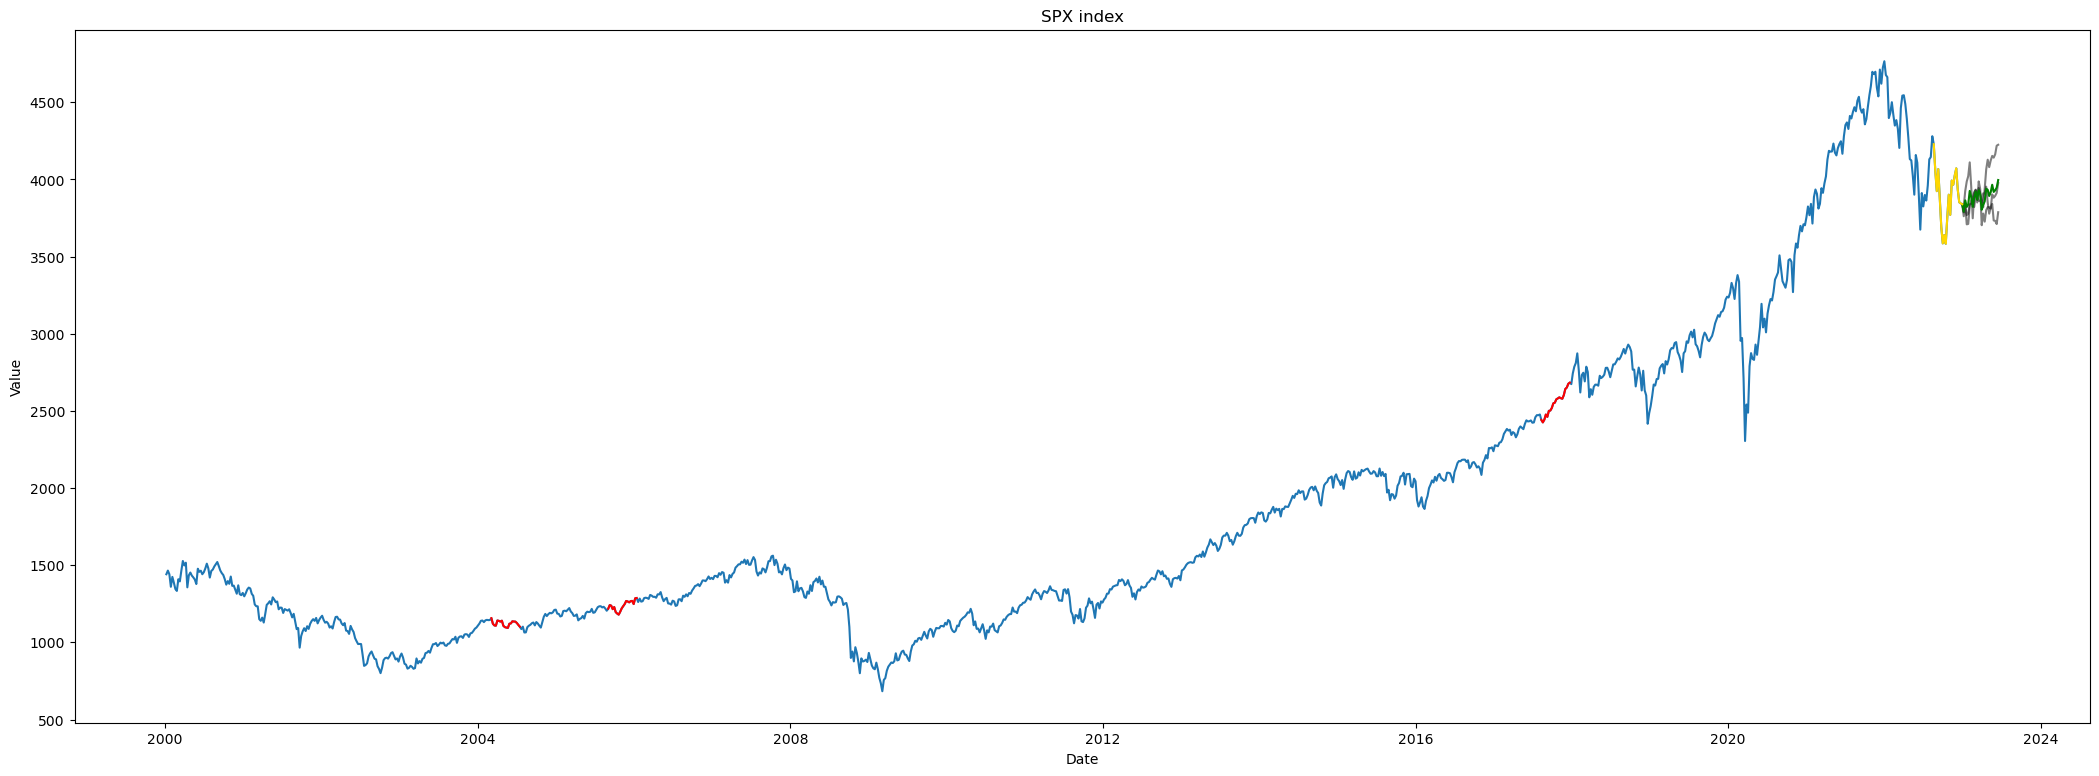

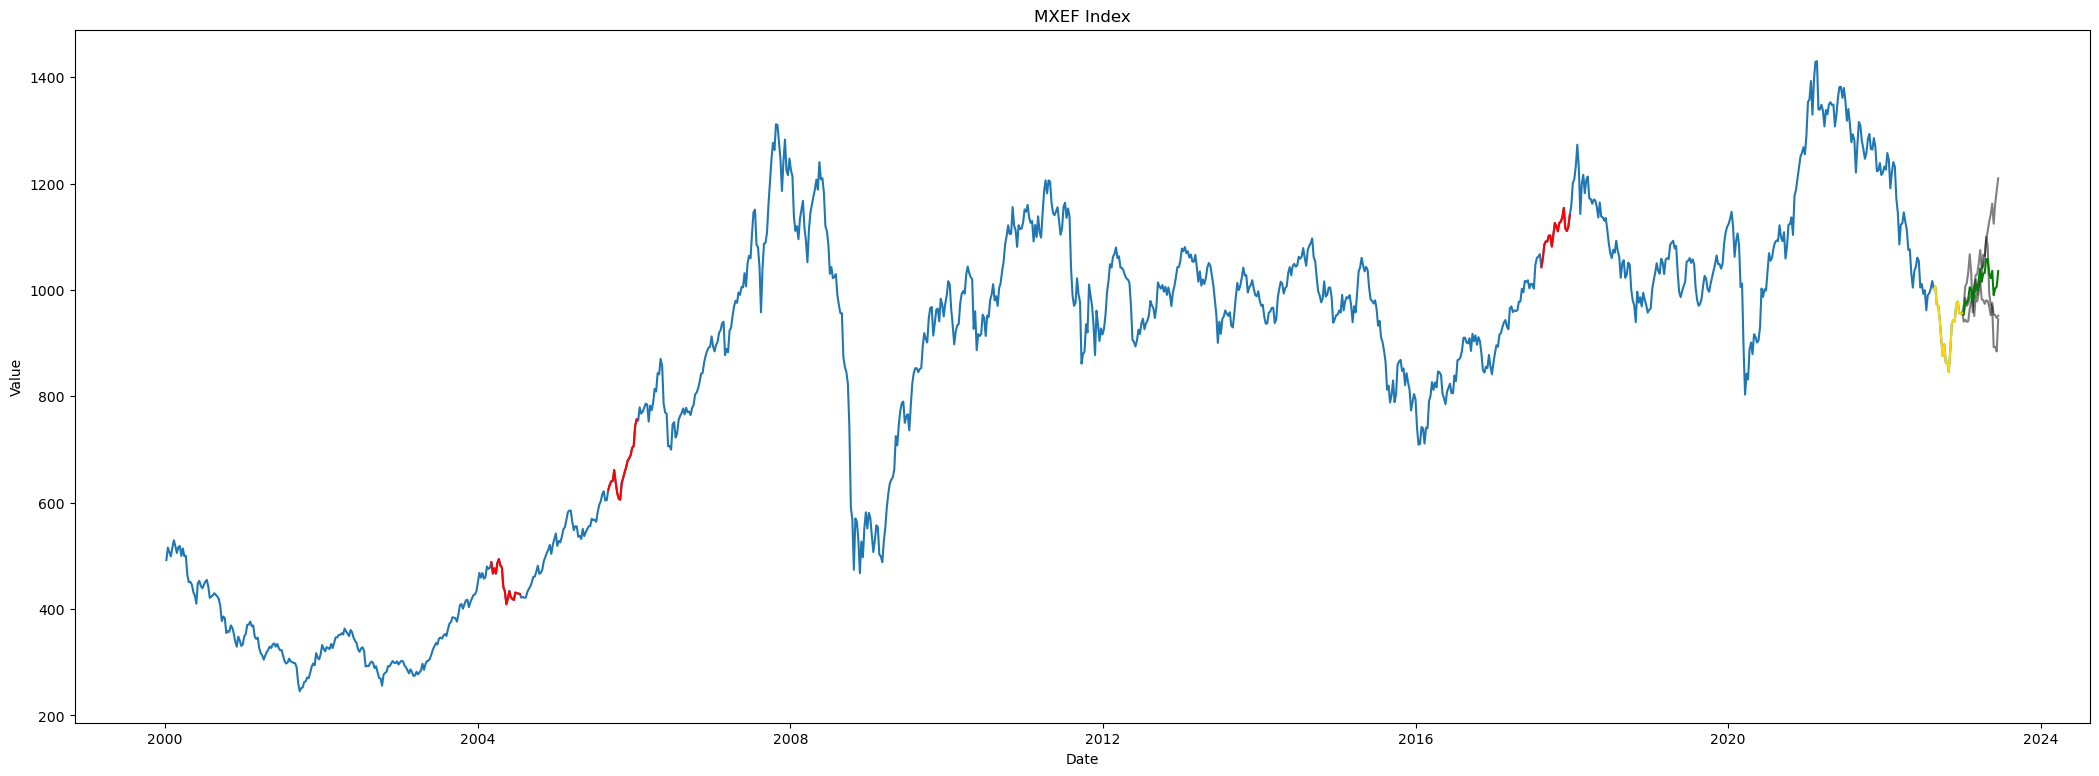

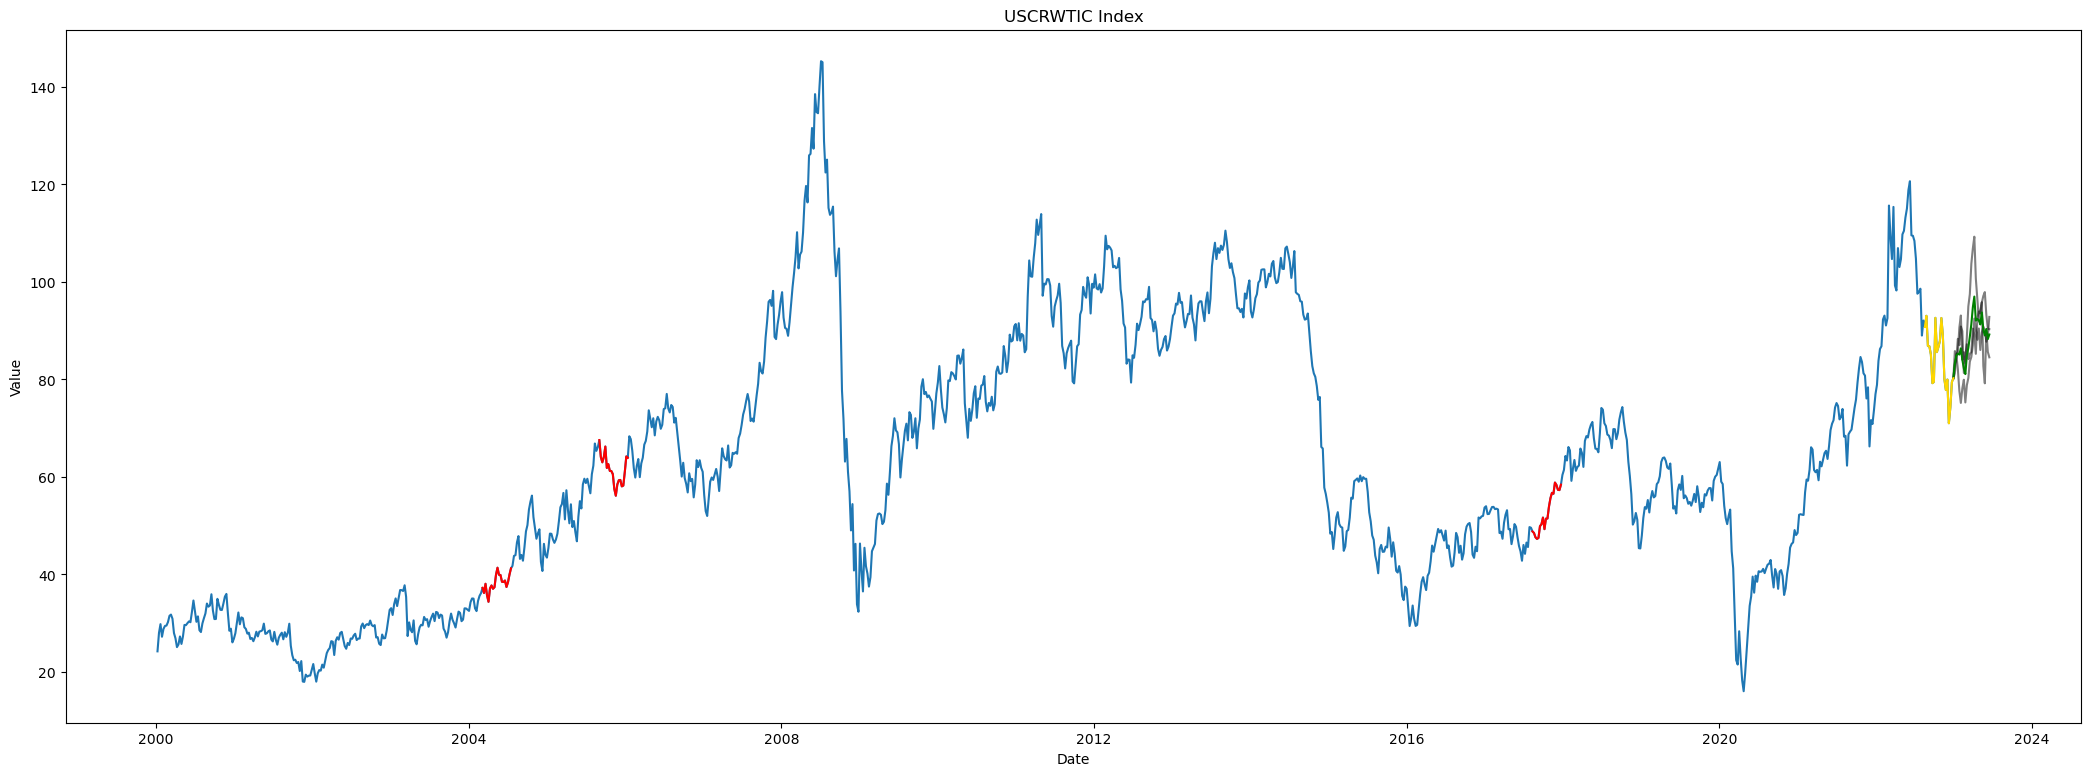

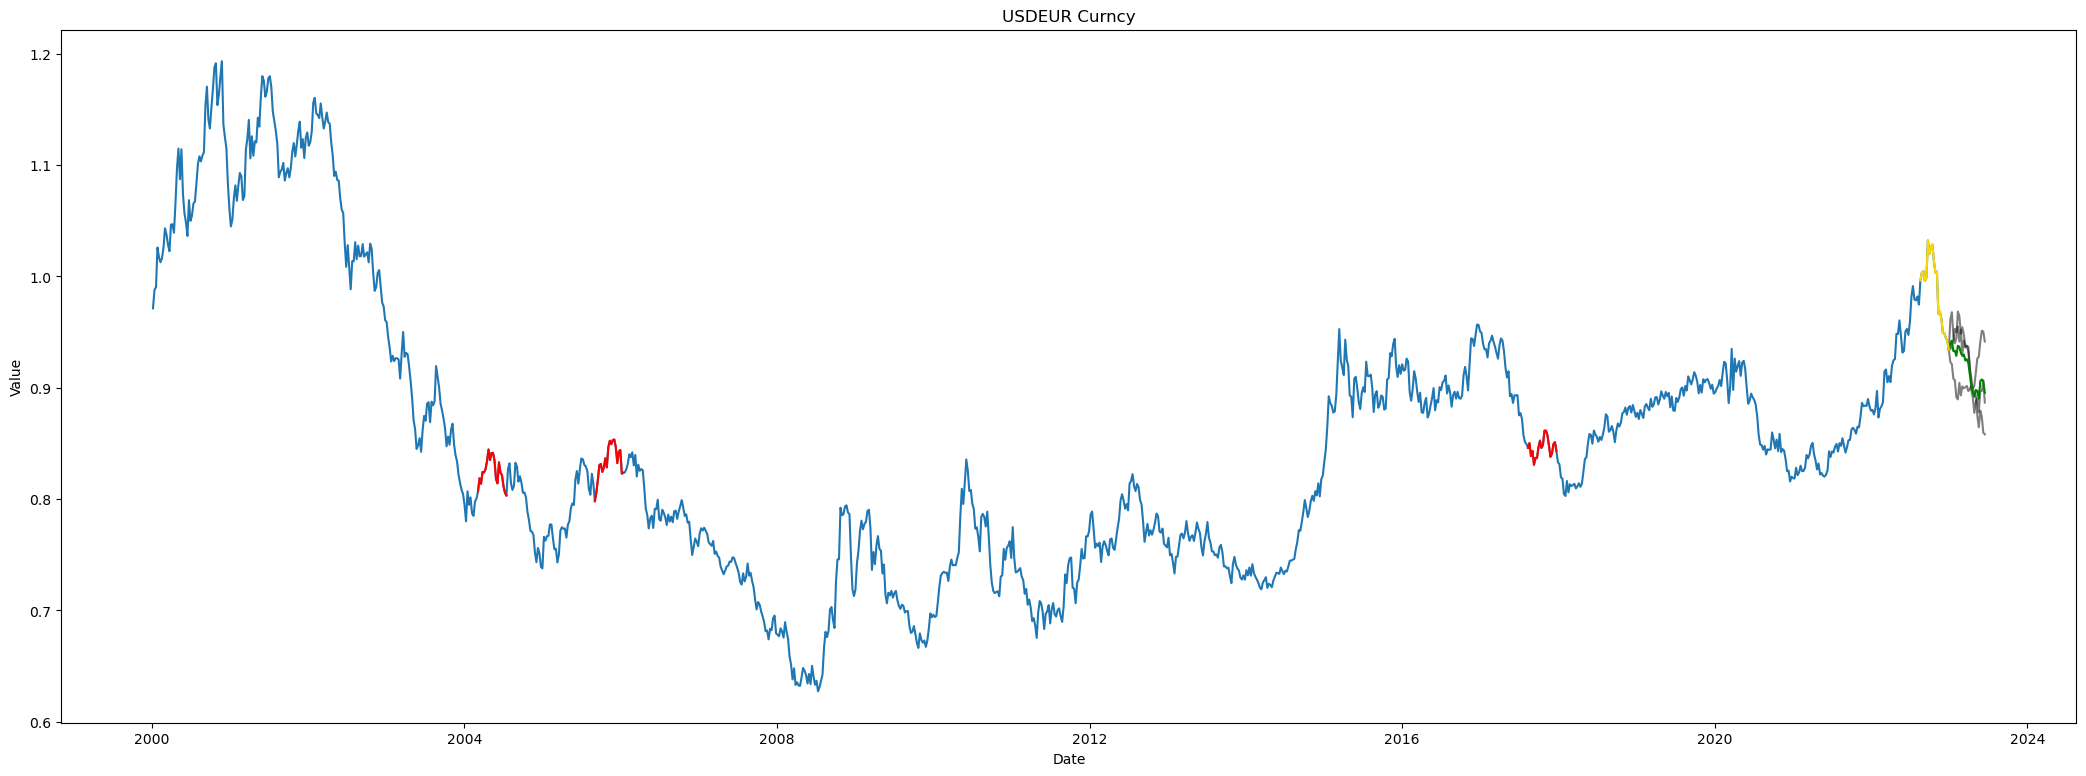

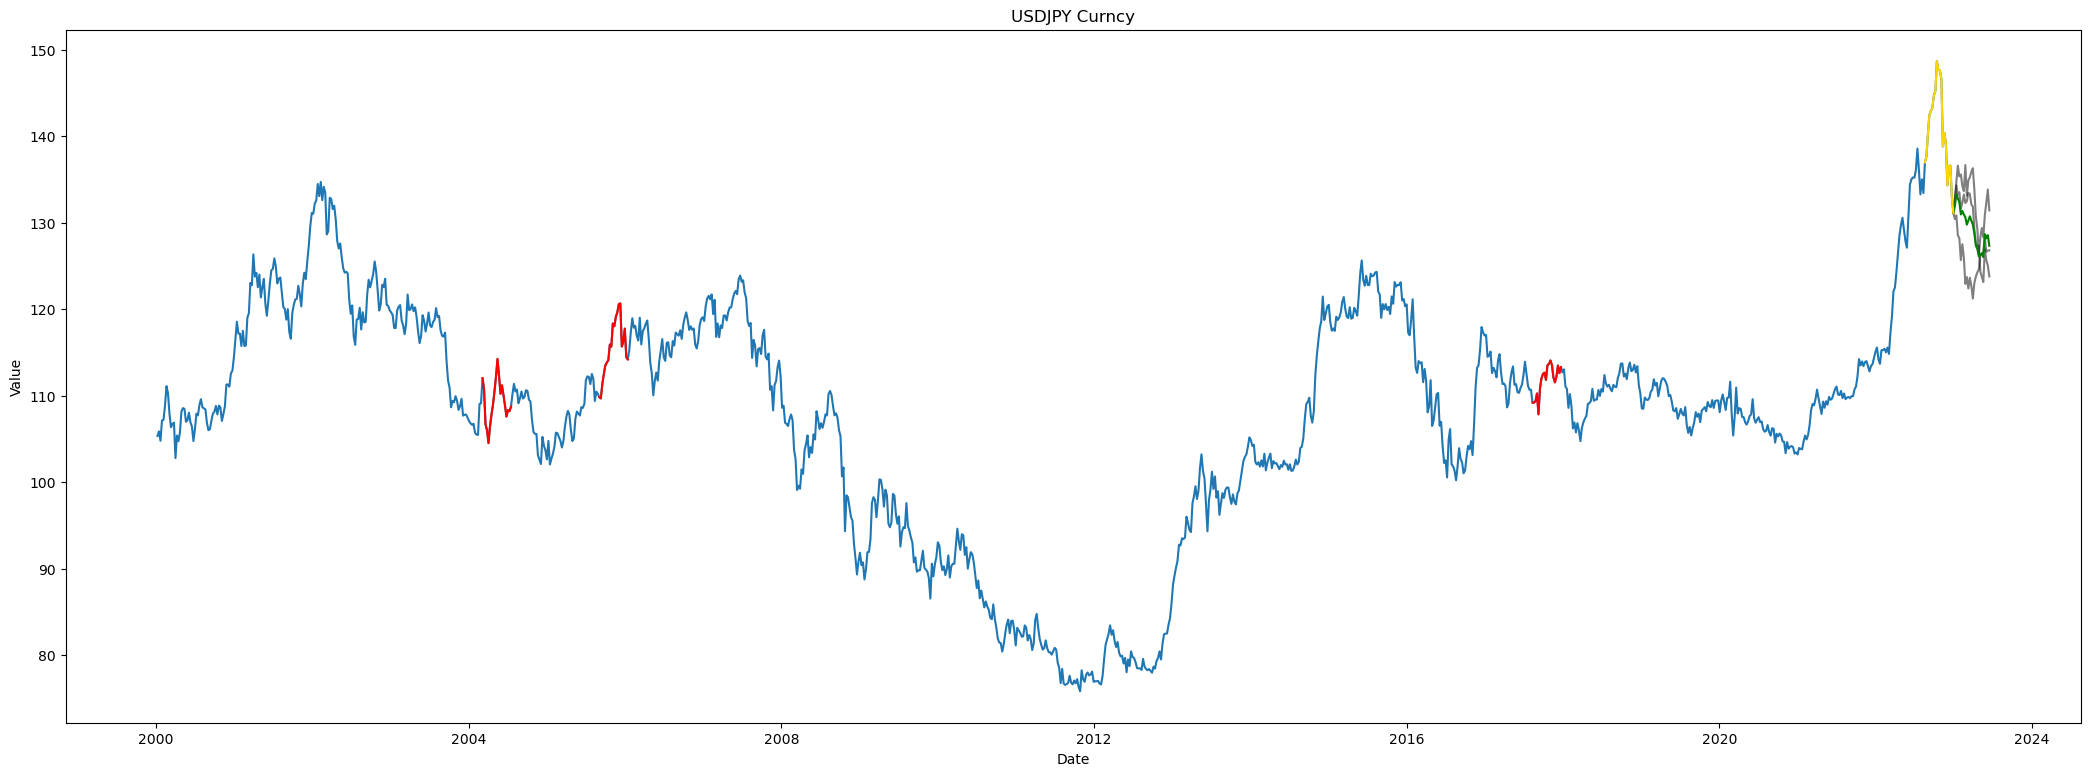

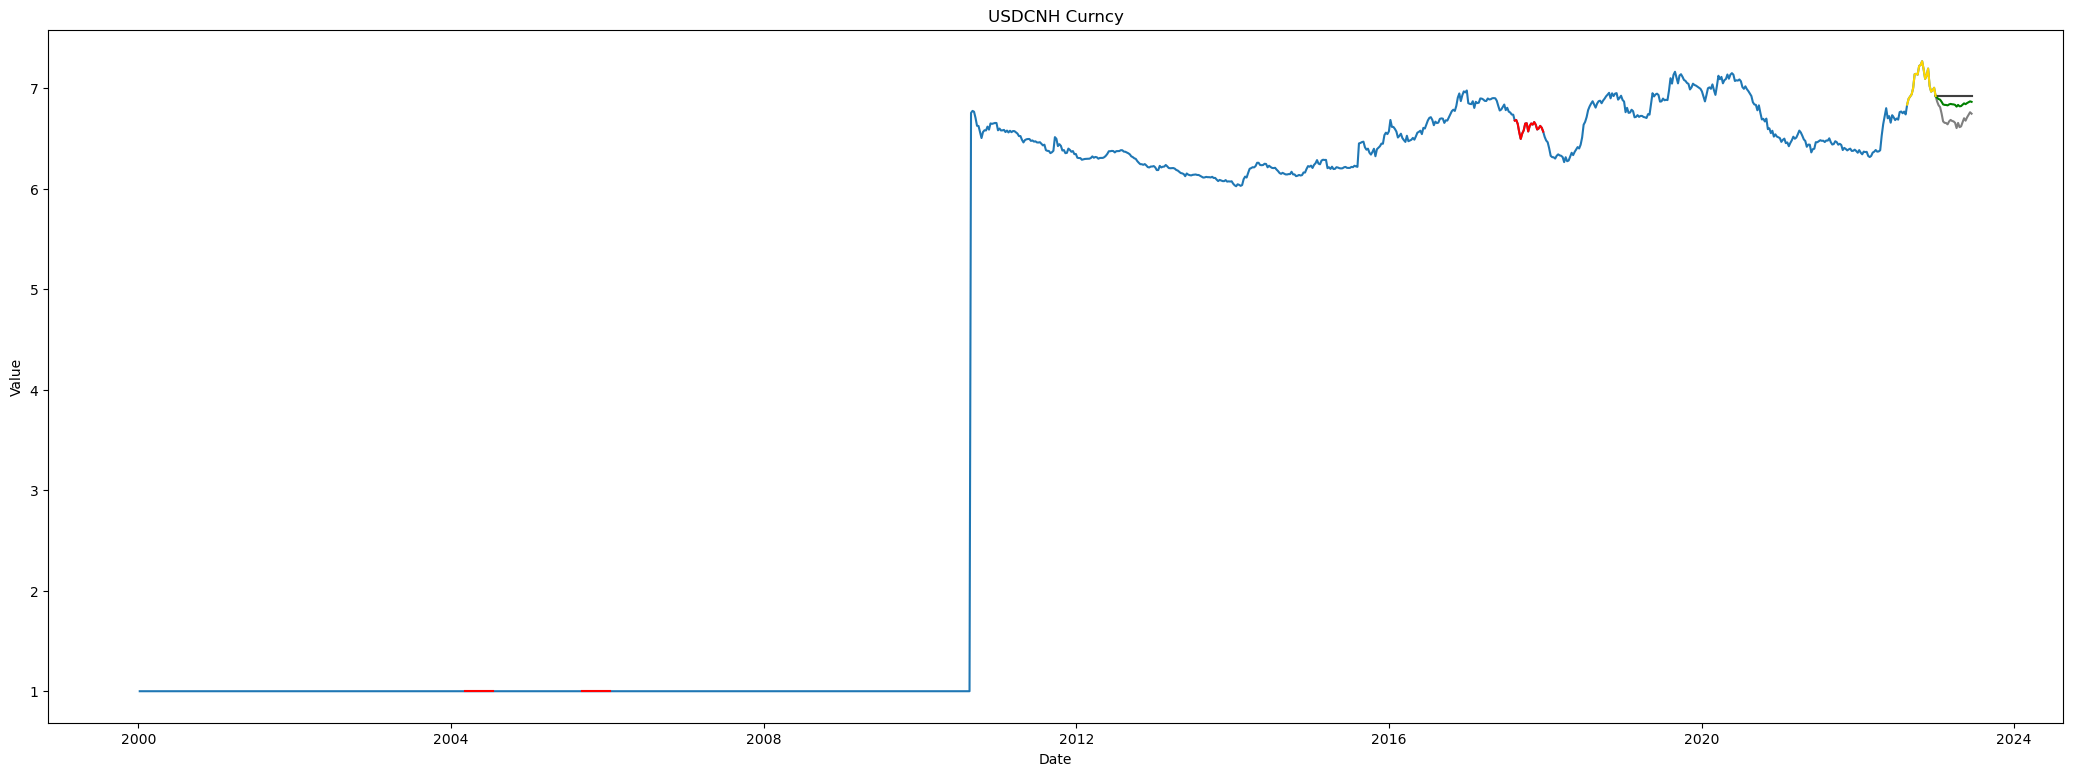

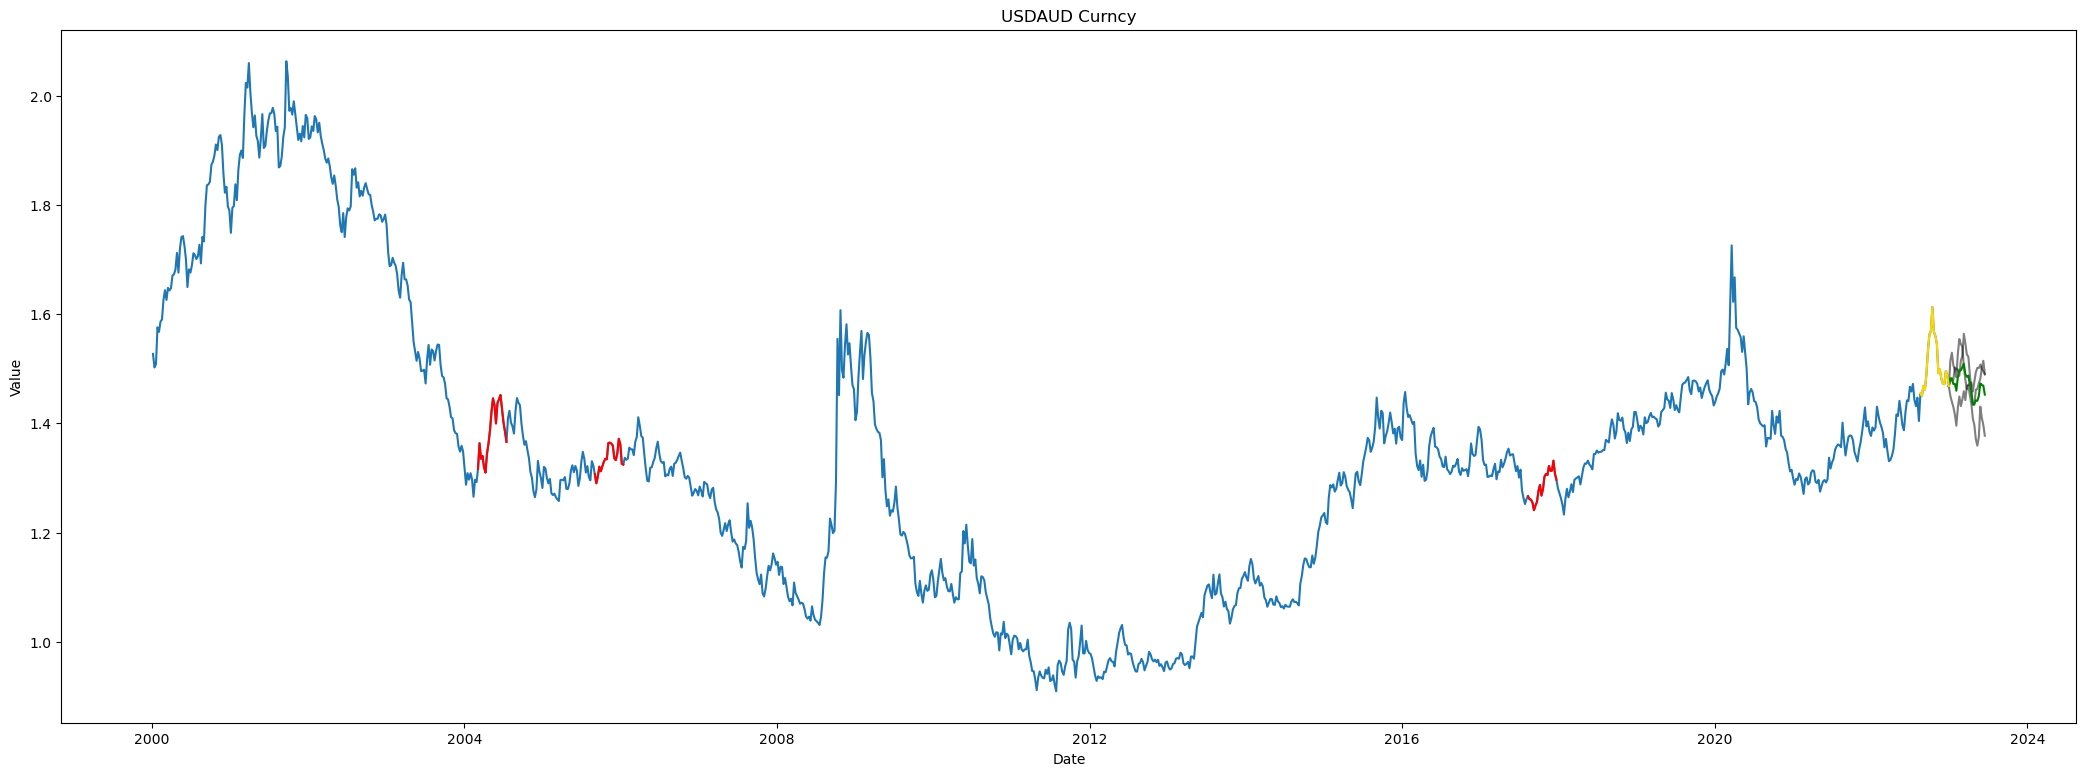

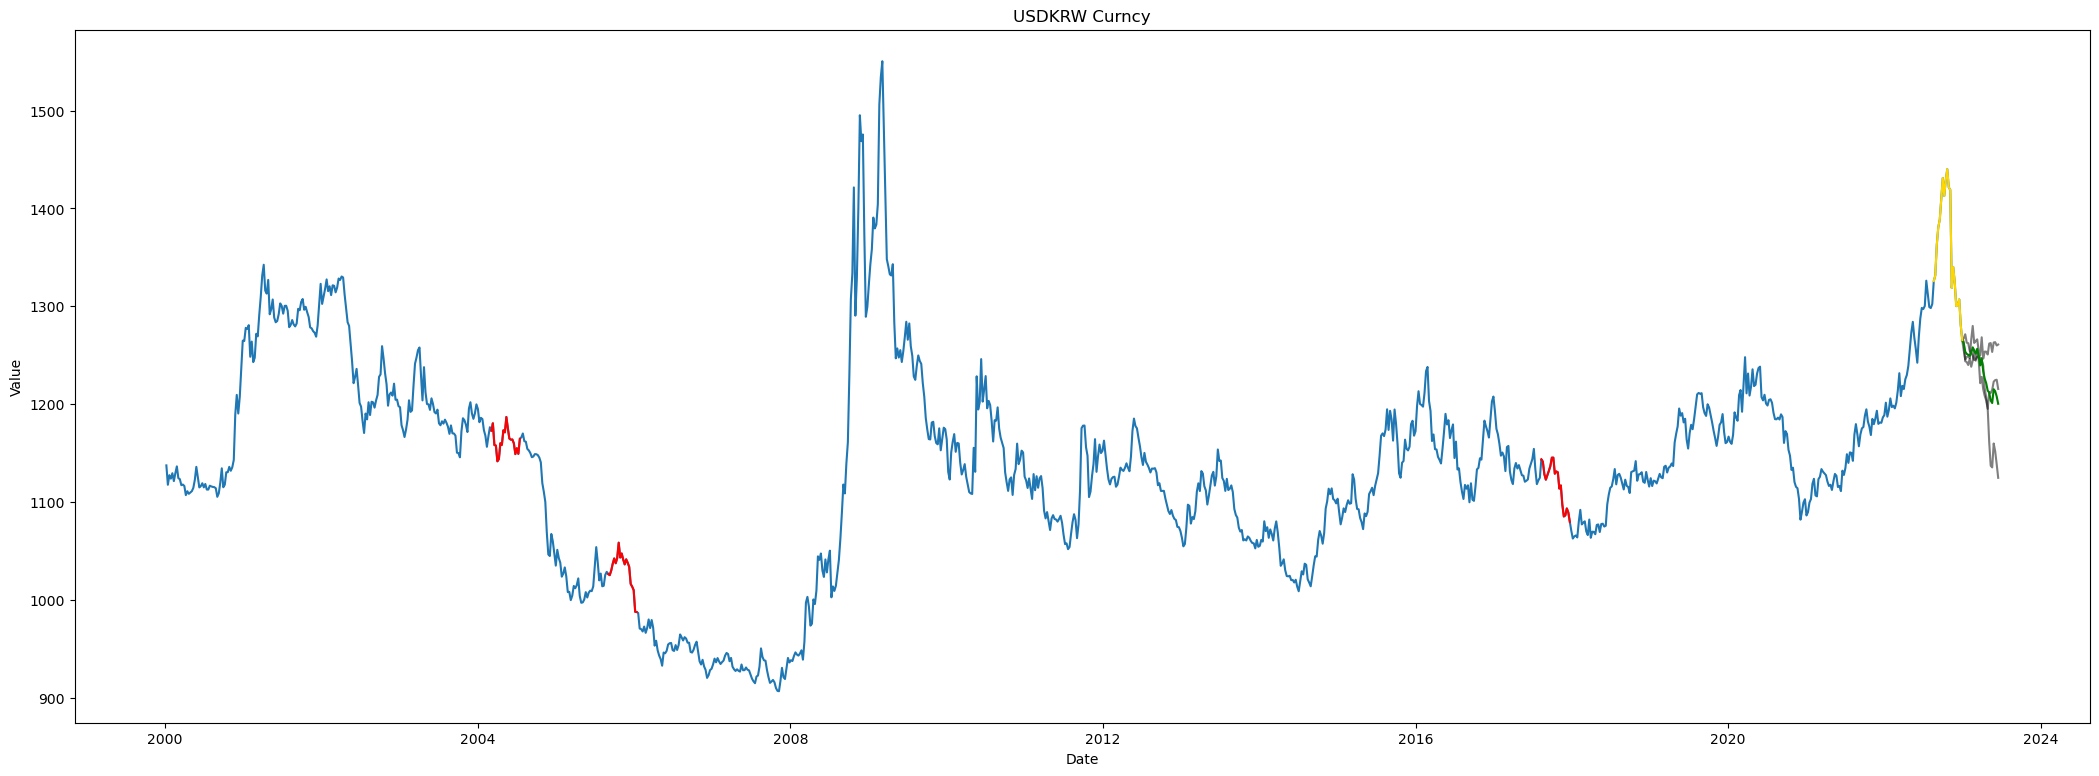

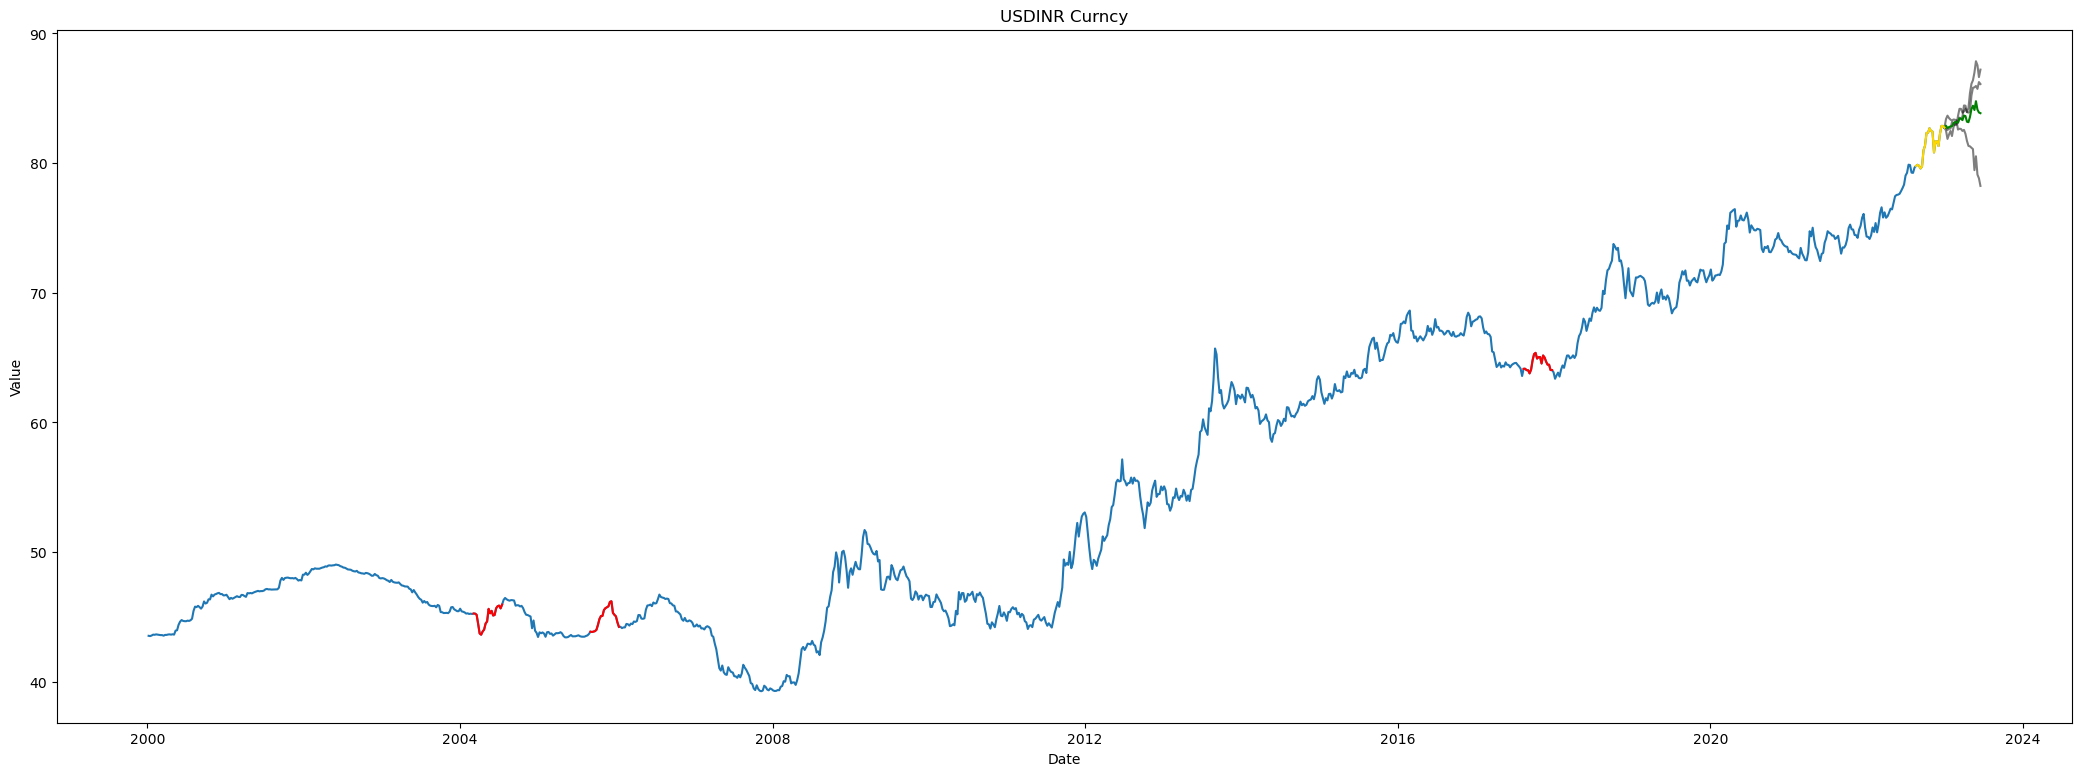

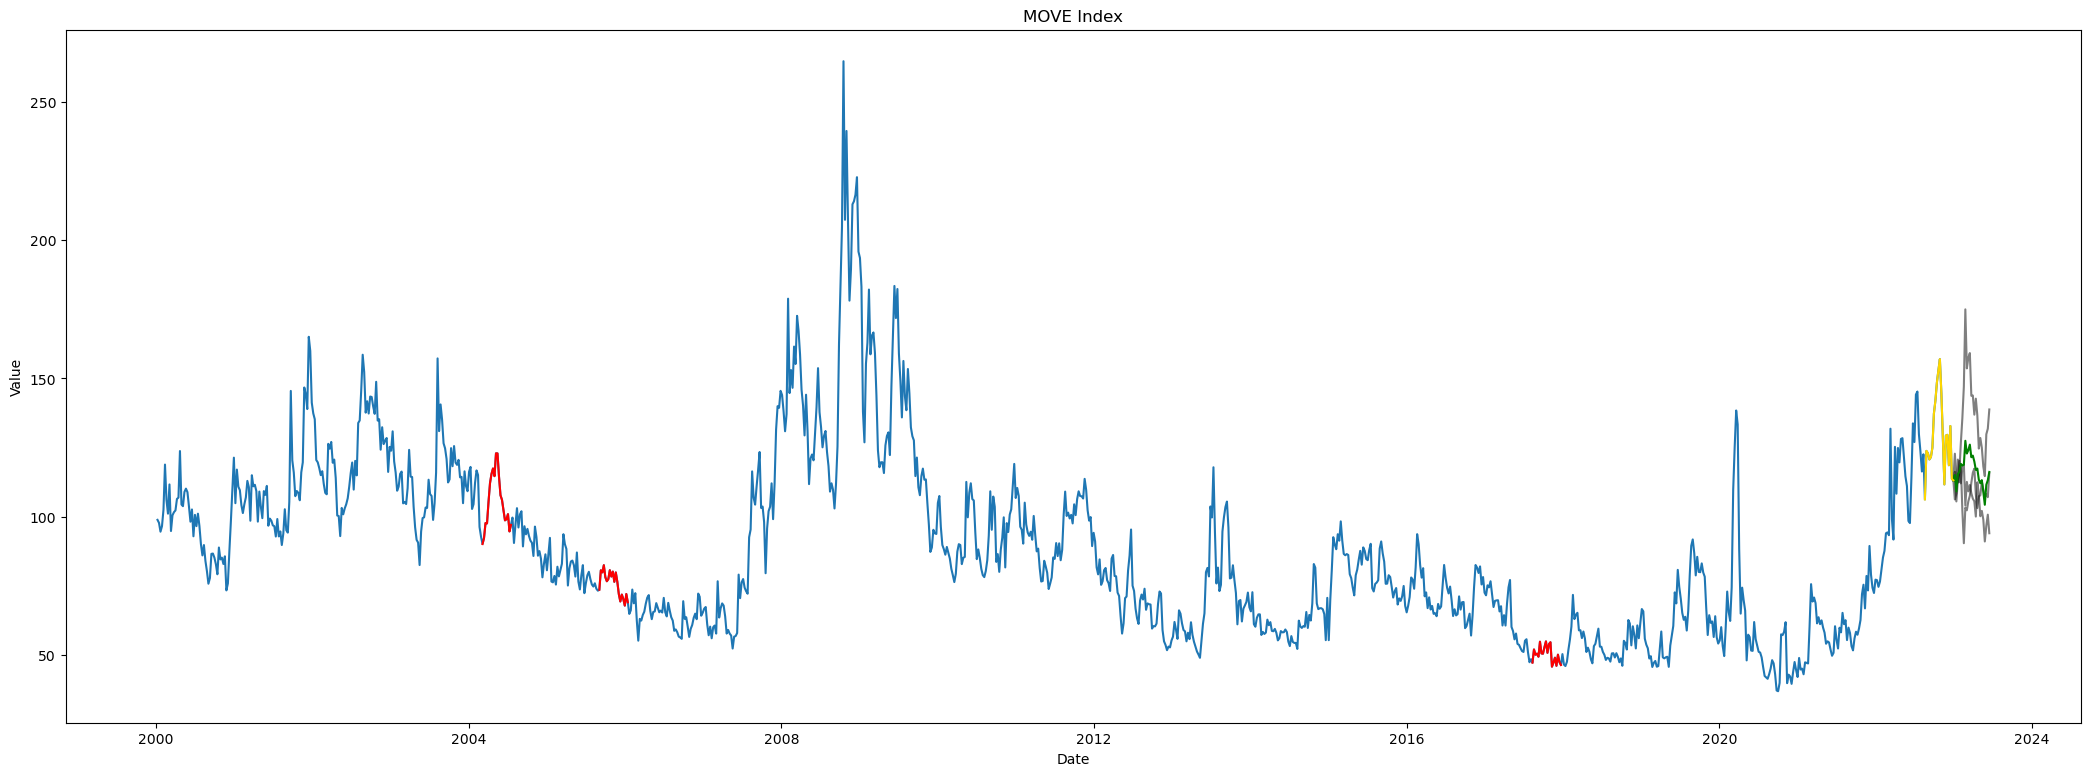

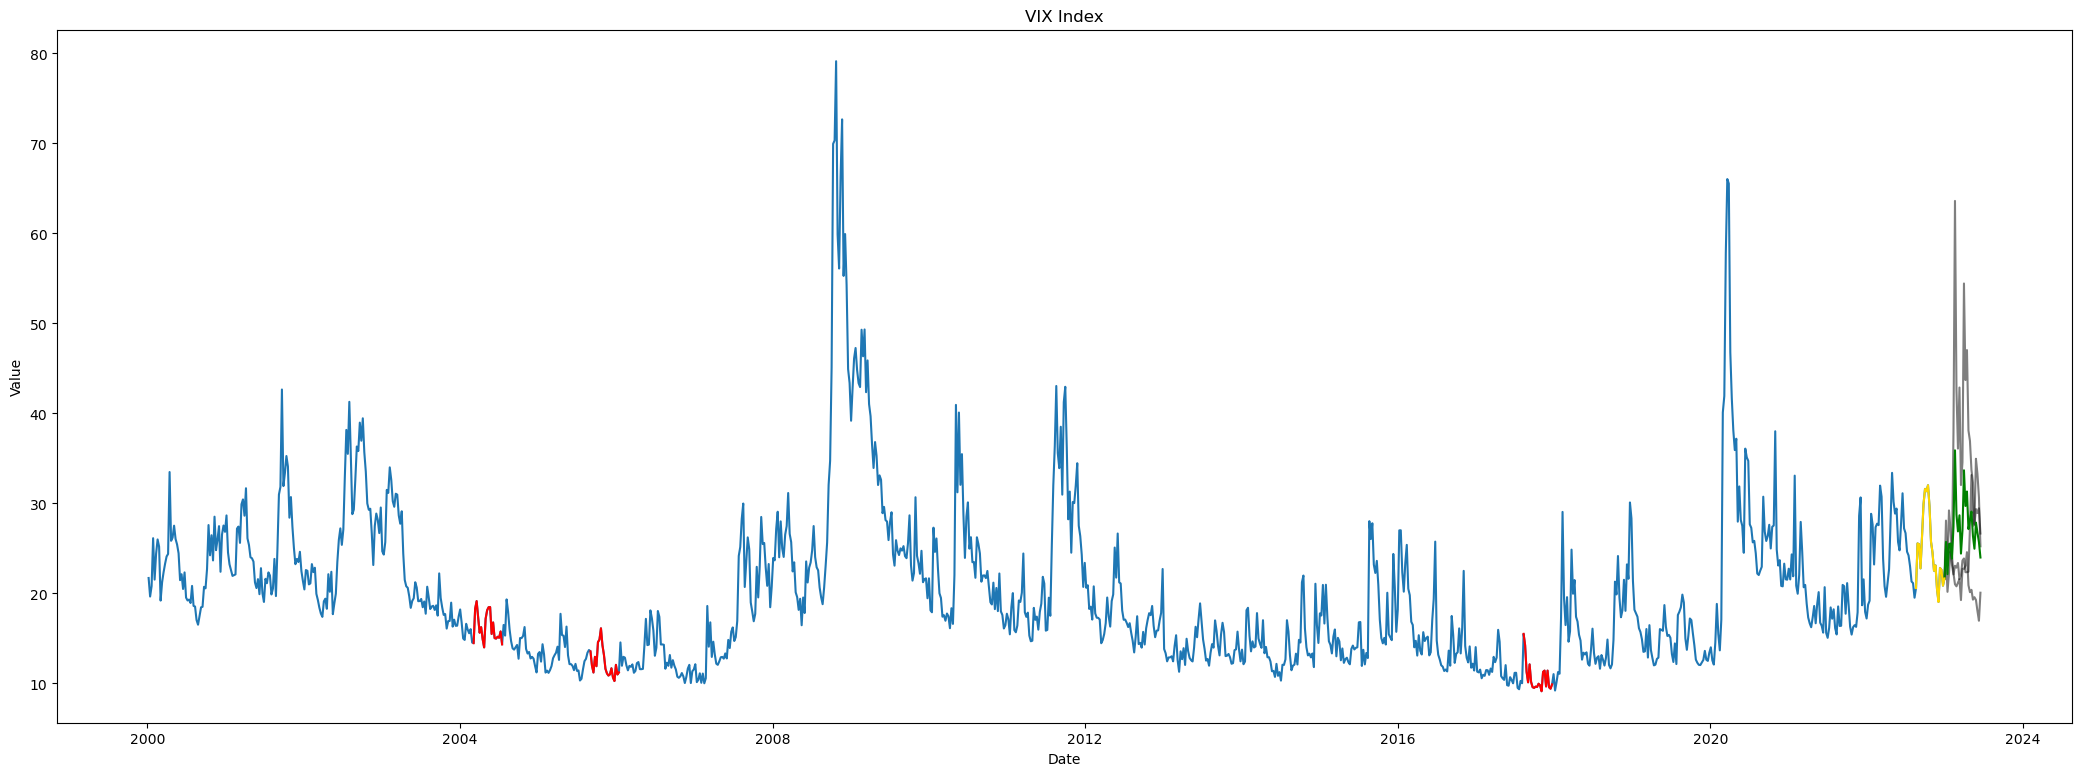

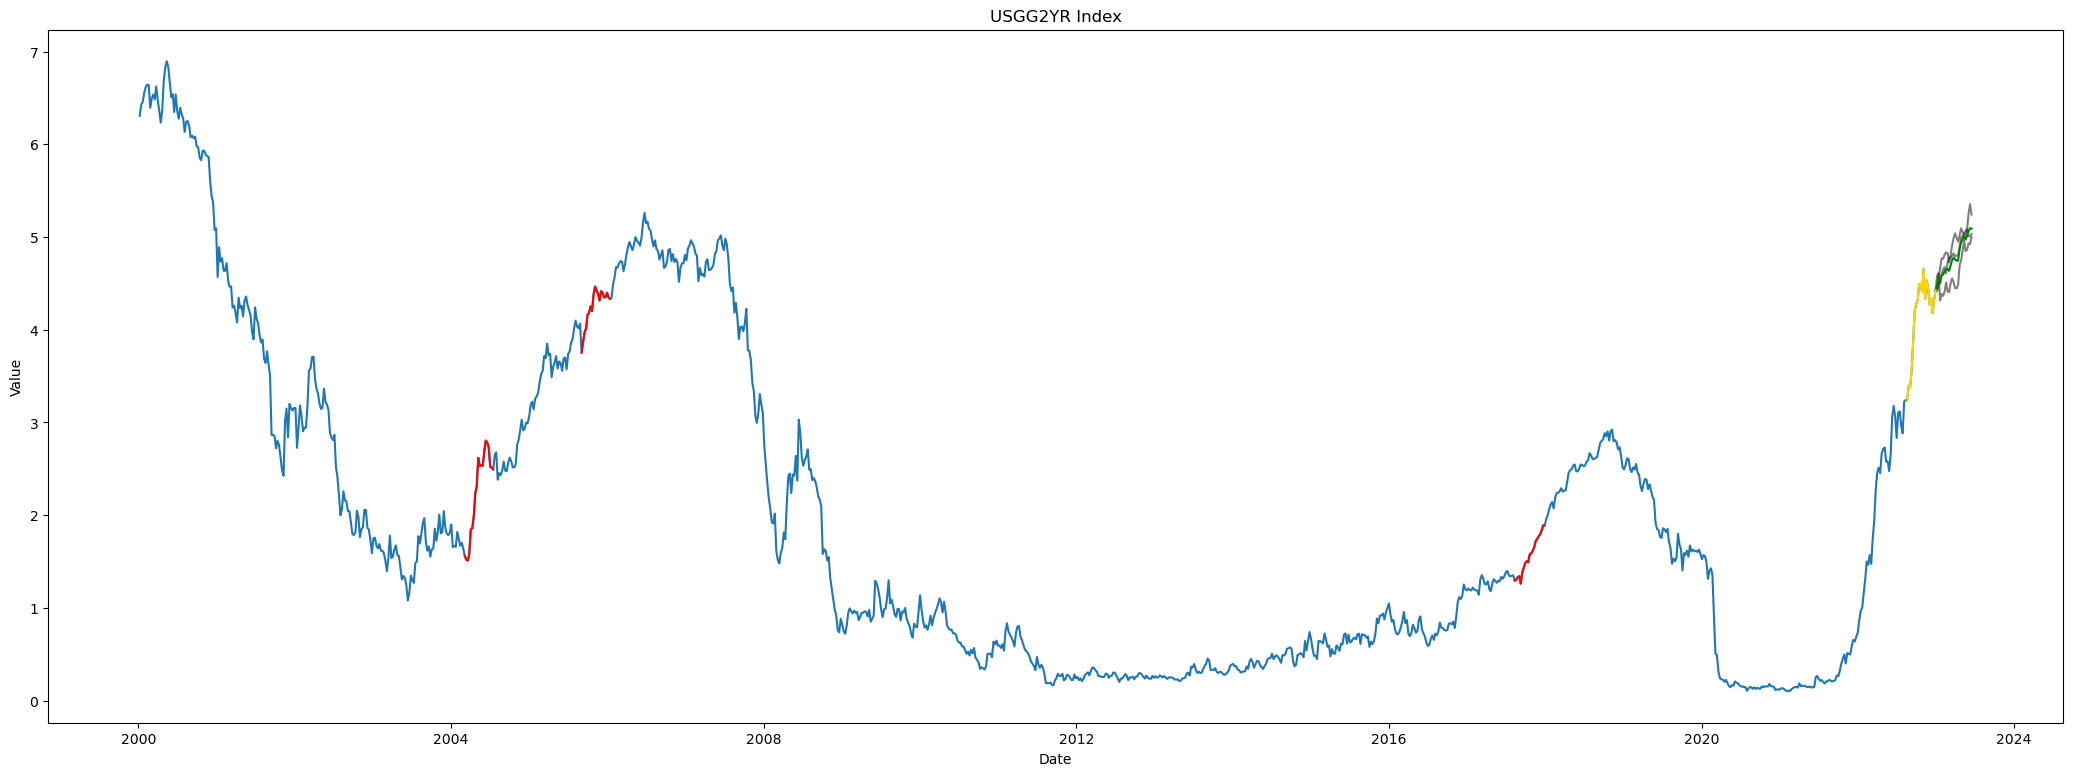

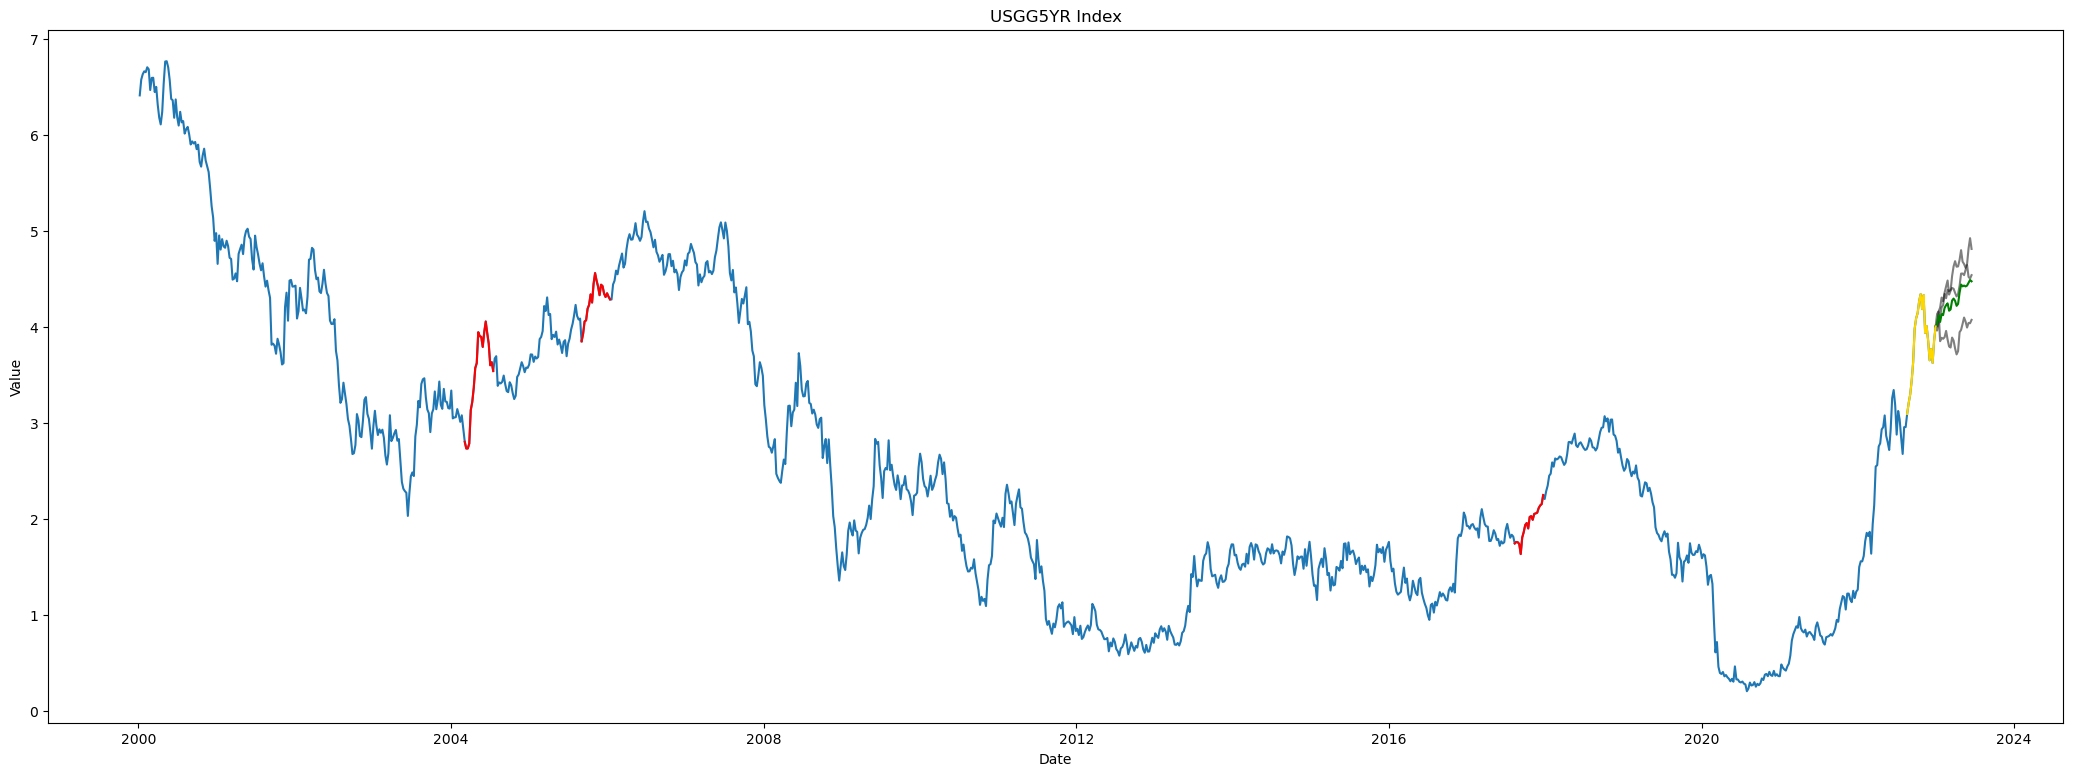

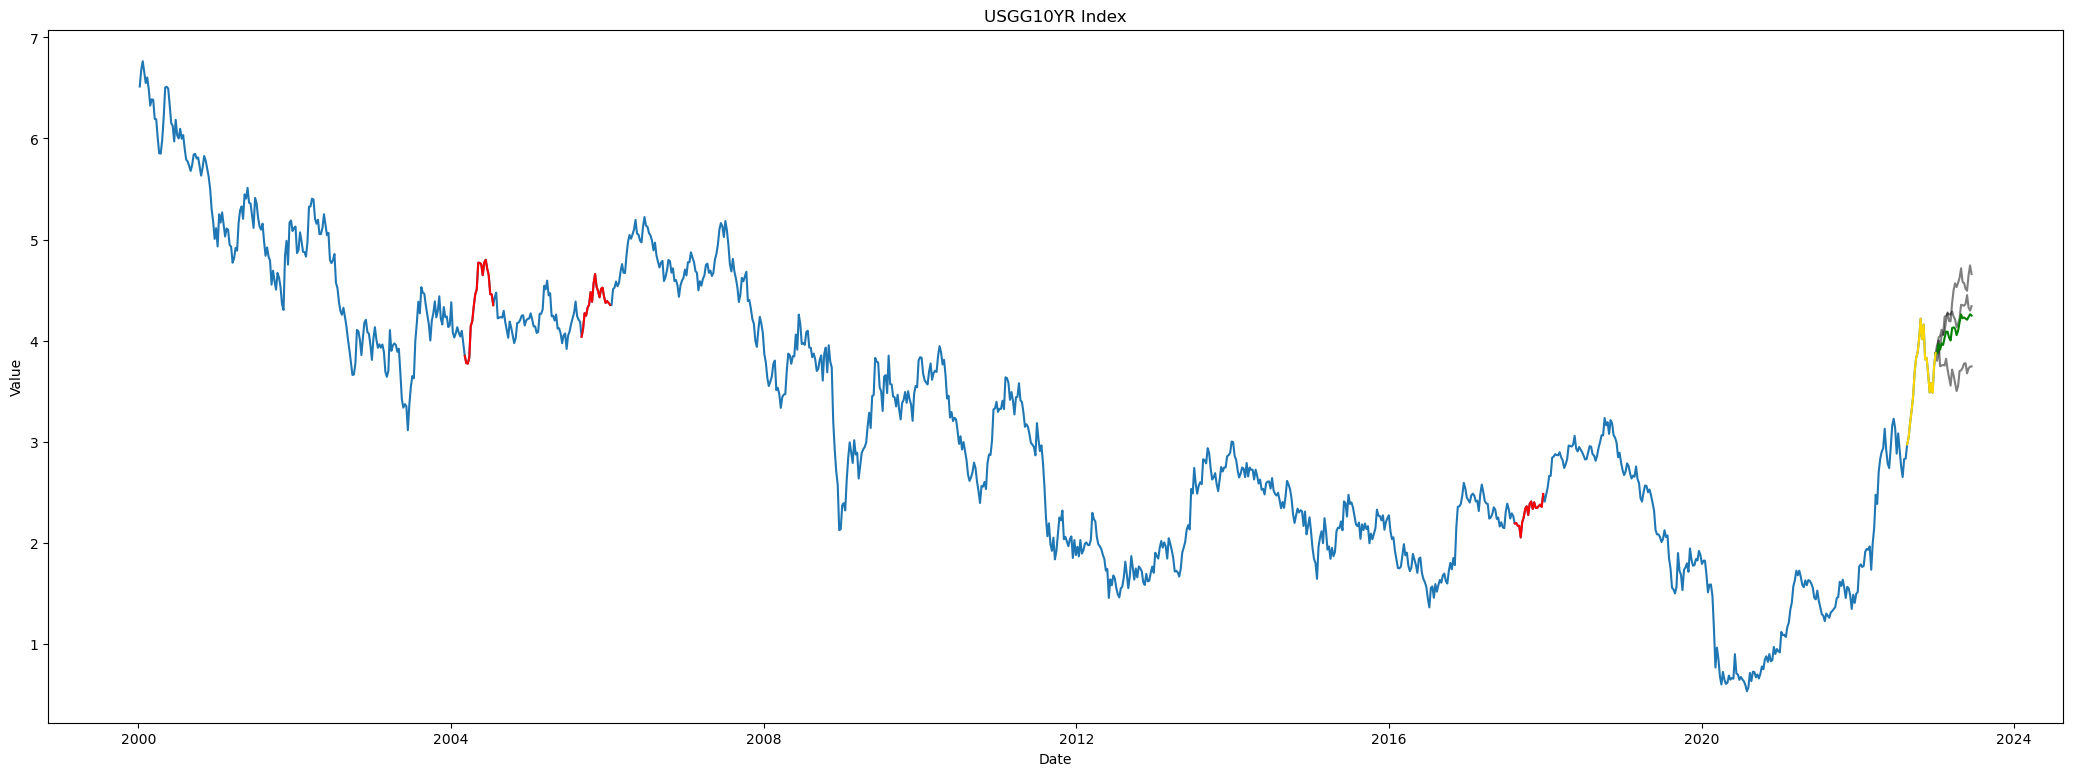

In [101]:
all_tsmd = All_TSMD(asset_price_list, date_list, asset_pchange_list, p_date_list, asset_name_list, 1180, 19, 3, True)
all_tsmd.fit()
all_tsmd.transform(25)
all_tsmd.plot()

In [63]:
class TSMD():
    def __init__(self, data_array):
        self.data_array = data_array
        self.e_dist_list = []
        self.n_smallest_e_dist_list = []
        self.n_smallest_index = []
        self.target_window = 0
    
    def search(self, search_target, n=3, p_change = True):
        if p_change:
            self.search_target = search_target
            target_window = len(self.search_target)
            self.target_window = target_window
            data_array = self.data_array

            e_dist_list = []
            for i in range(len(data_array) - target_window + 1):
                compare_array = data_array[i:i+target_window]
                E_dist = np.linalg.norm(np.array(compare_array) - np.array(search_target))
                e_dist_list.append(E_dist)
            self.e_dist_list = e_dist_list
            n_smallest_e_dist_list = np.partition(e_dist_list, n)[:n]

            self.n_smallest_e_dist_list = n_smallest_e_dist_list

            n_smallest_index = np.where(np.isin(e_dist_list, n_smallest_e_dist_list))[0]
            self.n_smallest_index = n_smallest_index
        else:
            self.search_target = search_target
            target_window = len(self.search_target)
            self.target_window = target_window
            data_array = self.data_array

            e_dist_list = []
            for i in range(len(data_array) - target_window + 1):
                compare_array = TimeSeriesScalerMeanVariance().fit_transform([data_array[i:i+target_window]])[0]
                E_dist = np.linalg.norm(np.array(compare_array) - TimeSeriesScalerMeanVariance().fit_transform([search_target])[0])
                e_dist_list.append(E_dist)
            self.e_dist_list = e_dist_list
            n_smallest_e_dist_list = np.partition(e_dist_list, n)[:n]

            self.n_smallest_e_dist_list = n_smallest_e_dist_list

            n_smallest_index = np.where(np.isin(e_dist_list, n_smallest_e_dist_list))[0]
            self.n_smallest_index = n_smallest_index

def plot(index_data_arr, index_date_arr, p_data_arr, p_date_arr, n_smallest_index, target_window, target_index):
    # plt.figure(figsize=(26, 9))
    # plt.plot(p_date_arr[:len(p_data_arr)], p_data_arr)
    # for index in n_smallest_index:
    #     plt.plot(p_date_arr[index:index+target_window], p_data_arr[index:index+target_window], 'r-')
    # plt.xlabel('Date')
    # plt.ylabel('Value')
    # plt.title('Time Series Data')
    # plt.show()

    plt.figure(figsize=(26, 9))
    plt.plot(index_date_arr[:len(index_data_arr)], index_data_arr)
    for index in n_smallest_index:
        plt.plot(index_date_arr[index:index+target_window], index_data_arr[index:index+target_window], 'r-')
    plt.plot(index_date_arr[target_index:target_index+target_window], index_data_arr[target_index:target_index+target_window], 'y-')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Time Series Data')
    plt.show()

In [ ]:
start_index = 0
window = 10
n = 5
per = False




tsdm_result = []
for i in range(len(training_asset_pchange_list)):
    tsmd = TSMD(training_asset_pchange_list[i])
    tsmd.search(testing_asset_pchange_list[i][start_index:start_index+window], n)
    tsdm_result.append(tsmd.e_dist_list)
e_dist_list = reduce(np.add, tsdm_result)
n_smallest_e_dist_list = np.partition(e_dist_list, n)[:n]
n_smallest_index = np.where(np.isin(e_dist_list, n_smallest_e_dist_list))[0]
print(n_smallest_index)
for i in range(len(asset_pchange_list)):
    target_index = 960+start_index
    plot(asset_price_list[i], date_list, asset_pchange_list[i], p_date_list, n_smallest_index, window, target_index)


In [ ]:
tsdm_result = []
for i in range(len(training_asset_price_list)):
    tsmd = TSMD(training_asset_price_list[i])
    tsmd.search(testing_asset_price_list[i][start_index:start_index+window], n, False)
    tsdm_result.append(tsmd.e_dist_list)
e_dist_list = reduce(np.add, tsdm_result)
n_smallest_e_dist_list = np.partition(e_dist_list, n)[:n]
n_smallest_index = np.where(np.isin(e_dist_list, n_smallest_e_dist_list))[0]
print(n_smallest_index)
for i in range(len(asset_pchange_list)):
    target_index = 960+start_index
    plot(asset_price_list[i], date_list, asset_pchange_list[i], p_date_list, n_smallest_index, window, target_index)